In [139]:
import matplotlib.image as mpimg
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2yiq
from collections import defaultdict 
import cv2
from tqdm import tqdm
%matplotlib inline

In [140]:
img_file = "nil_test.png"
img_file_scribbled = "nil_test_s.png"

In [141]:
img = io.imread(img_file)
img_s = io.imread(img_file_scribbled)
print(img.dtype, img.shape)
g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
g_img_s = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)


uint8 (321, 481, 4)


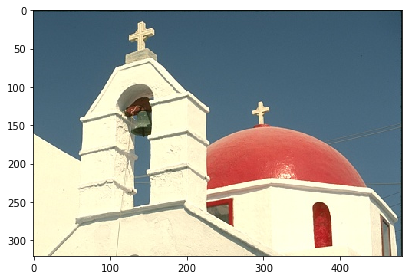

In [142]:
io.imshow(img)

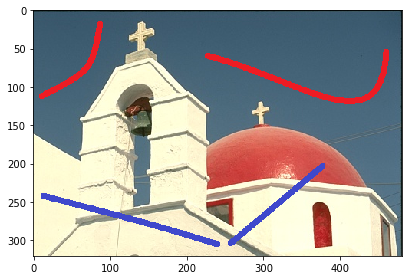

In [143]:
io.imshow(img_s)

In [144]:
scribble = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if g_img[i,j] !=  g_img_s[i,j]:
            scribble.append((i,j))
# print(scribble)

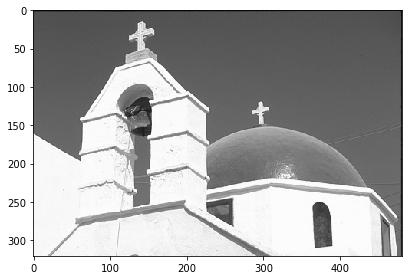

In [145]:
io.imshow(g_img)

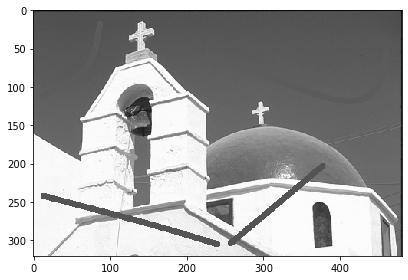

In [146]:
io.imshow(g_img_s)

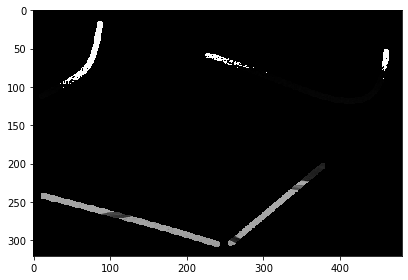

In [147]:
diff = g_img - g_img_s
io.imshow(diff)
io.imsave('diff.png', diff)

In [148]:
scribble_diff = []
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if diff[i,j] > 0:
            scribble_diff.append((i,j))
# print(scribble_diff)

In [149]:
scribble == scribble_diff # Need to see why 

True

In [150]:
img_s_key = set()
rgb_s = mpimg.imread(img_file_scribbled)[:,:,:3]
yuv_s = rgb2yiq(rgb_s)
for i, j in scribble:
    img_s_key.add(tuple(rgb_s[i,j,:3]))
img_s_key # should only have two values
# Need to check that the scribbles are purely a single colour and do not shade at the edges

{(0.24705882, 0.28235295, 0.8), (0.92941177, 0.10980392, 0.14117648)}

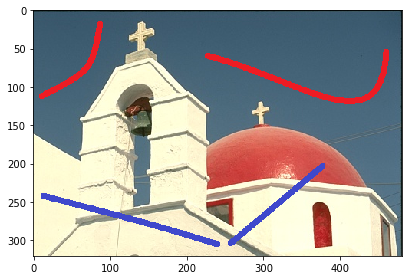

In [151]:
io.imshow(img_s)

In [152]:
def find_marked_locations(rgb, rgb_s):
    g = cv2.cvtColor(io.imread(rgb), cv2.COLOR_RGB2GRAY)
    g_s = cv2.cvtColor(io.imread(rgb_s), cv2.COLOR_RGB2GRAY)
    scribble = []
    non_scribble = []
    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if g[i,j] !=  g_s[i,j]:
                scribble.append((i, j))
            else:
                non_scribble.append((i, j))
    return scribble, non_scribble

In [153]:
def assign_scribble_pixels():
    scribbles_pos, _ = find_marked_locations(img_file, img_file_scribbled)
    scribbles_pos_dict = defaultdict(list)
    rgb_s = mpimg.imread(img_file_scribbled)[:,:,:3]
    for pos in scribbles_pos:
        if tuple(rgb_s[pos[0], pos[1]]) in img_s_key:
            scribbles_pos_dict[tuple(rgb_s[pos[0], pos[1]])].append(pos)
    
    # Sanity Check 
    print(len(scribbles_pos_dict))
    l = 0
    for k in scribbles_pos_dict:
        l += len(scribbles_pos_dict[k])
    
    if l == len(scribbles_pos):
        print('OK')
    # ------------
    return scribbles_pos_dict

scribbles_pos_dict = assign_scribble_pixels()
list(scribbles_pos_dict.keys())

2
OK


[(0.92941177, 0.10980392, 0.14117648), (0.24705882, 0.28235295, 0.8)]

In [154]:
def compute_pdfs(imfile, imfile_scrib):
    rgb = mpimg.imread(imfile)[:,:,:3]
    yuv = rgb2yiq(rgb)
    rgb_s = mpimg.imread(imfile_scrib)[:,:,:3]
    yuv_s = rgb2yiq(rgb_s)
    # io.imshow(rgb)
    # io.imshow(rgb_s)
        
    # find the scribble pixels    
    # scribbles = find_marked_locations(rgb, rgb_s)
    scribbles, _ = find_marked_locations(imfile, imfile_scrib)
    if not scribbles:
        raise Exception

    imageo = np.zeros(yuv.shape)
    
    # separately store background and foreground scribble pixels in the dictionary comps
    comps = defaultdict(lambda:np.array([]).reshape(0,3))
    for (i, j) in scribbles:
         imageo[i,j,:] = rgb_s[i,j,:]
         # scribble color as key of comps
         comps[tuple(imageo[i,j,:])] = np.vstack([comps[tuple(imageo[i,j,:])], yuv[i,j,:]])
    mu, sigma = {}, {}
    # compute MLE parameters for Gaussians
    for c in comps:
         mu[c] = np.mean(comps[c], axis=0)
         sigma[c] = np.cov(comps[c].T)
    return (mu, sigma)

In [155]:
# Check to see what they mean
m, s = compute_pdfs(img_file, img_file_scribbled)

In [156]:
m

{(0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([ 0.35980652, -0.09774212, -0.00128617]),
 (0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([ 0.88413985,  0.0736122 , -0.02605935])}

In [157]:
#for val in s:
#    s[val] = s[val] * 2

In [158]:
s

{(0.929411768913269,
  0.10980392247438431,
  0.1411764770746231): array([[ 2.26032347e-04, -8.27541092e-10,  4.21119503e-07],
        [-8.27541092e-10,  1.02512655e-06, -5.54215913e-07],
        [ 4.21119503e-07, -5.54215913e-07,  5.78608439e-07]]),
 (0.24705882370471954,
  0.2823529541492462,
  0.800000011920929): array([[ 0.03067441, -0.00791643, -0.00541745],
        [-0.00791643,  0.00500324,  0.00255288],
        [-0.00541745,  0.00255288,  0.00145199]])}

In [159]:
import scipy.stats as ss 
pixel_val = rgb_s[0,0,:]

k1, k2 = list(scribbles_pos_dict.keys())
var0 = ss.multivariate_normal.pdf(pixel_val,m[k1], s[k1])
var0

0.0

In [160]:
k2

(0.24705882, 0.28235295, 0.8)

In [161]:
var1 = ss.multivariate_normal.pdf(pixel_val, m[k2], s[k2])
var1

7.308677137595295e-33

In [162]:
#non_scribbles_pos[20001]


In [163]:
var2 = var0 + var1
print(var1, ": ",var2)
print(var0/var2, var1/var2) # Source and Sink Weights 

7.308677137595295e-33 :  7.308677137595295e-33
0.0 1.0


## Constructing Graph for QA with Source and Sink nodes

In [164]:
s_J = {}
r, c = g_img.shape[:2]
print("c = ",r*c)
#k1, k2 = list(scribbles_pos_dict.keys())

red = (0.92941177, 0.10980392, 0.14117648)
blue = (0.24705882, 0.28235295, 0.8)
for pos in scribbles_pos_dict[blue]:
    s_J[(pos[0]*c + pos[1], 's')] = -99
    s_J[(pos[0]*c + pos[1], 't')] = -.5

for pos in scribbles_pos_dict[red]:
    s_J[(pos[0]*c + pos[1], 't')] = -99
    s_J[(pos[0]*c + pos[1], 's')] = -.5


c =  154401


In [165]:
scribbled_pos, non_scribbles_pos = find_marked_locations(img_file, img_file_scribbled)
print(len(non_scribbles_pos))
assert (len(scribbled_pos) + len(non_scribbles_pos)) == r*c
(len(scribbled_pos) + len(non_scribbles_pos))

148154


154401

In [166]:
## assigning total_pixel - scribble_pixels probabilities of background or foreground using PDF function

In [167]:
rgb_s = mpimg.imread(img_file_scribbled)[:,:,:3]
#print(rgb_s[0,0,:])
#print("************* ",len(non_scribbles_pos))
non_s_j = {}
rgb = mpimg.imread(img_file)[:,:,:3]
cnt = 0

mult_factor_lambda = 2
for i, pos in tqdm(enumerate(non_scribbles_pos)):
    
    var0 = ss.multivariate_normal.pdf(rgb[pos[0],pos[1],:], m[k1], s[k1])
    var1 = ss.multivariate_normal.pdf(rgb[pos[0],pos[1],:], m[k2], s[k2])
    
   
    #print("var0: {} var1:{} res0:{}, res1:{} ".format(var0, var1, res0, res1))
    import math
    if var0 == 0 or var1 == 0:
        if var0 == 0: 
            res0 = 1
            
        elif var1 == 0:
            # print("var0: {} var1:{} res0:{}, res1:{} ".format(var0, var1, res0, res1))
            # print("pos: {}", pos)
            res1 = 99
        cnt +=1
    else:
        res = var0 + var1
        res0 = var0/res
        res1 = var1/res
        
    #print("******** got var1: {}, var2: {}".format(var0, var1))
    
    non_s_j[(pos[0]*c + pos[1], 's')] = - (mult_factor_lambda * np.log(res0))
    non_s_j[(pos[0]*c + pos[1], 't')] = -(mult_factor_lambda * np.log(res1))
    #print(res0, " : ", res1)
print("total:{} nane:{}".format(i, cnt))

148154it [00:27, 5385.71it/s]total:148153 nane:148154



In [168]:
rgb[0,0,:]
ss.multivariate_normal.pdf(rgb[82,82,:], m[k2], s[k2])
#total:66026 nane:47191
print((len(scribbled_pos)))
print(66026-47191)

6247
18835


--------------------------------------------------
## Constructing Graph for QA from g_img Intensities

In [169]:
for i, pxi in enumerate(g_img):
    for j, pxij in enumerate(pxi):
        pass
print(i, j, pxij)
g_img[0,0]

320 480 35


31

In [170]:
import math
import dimod
std = np.std(g_img)

rgb_t = np.reshape(rgb.T, (3,-1)) # images.shape = (3,5120000)
std = np.std(rgb_t, axis = 1)
std

array([0.33845612, 0.28730926, 0.20735247], dtype=float32)

#### Constructing QUBO Model BQM

In [171]:
# bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
# for i, pxi in enumerate(g_img):
#     for j, pxij in enumerate(pxi):
#         # Just putting Intensity for now
#         bqm.add_variable(i*c + j, pxij)

# for i, pxi in tqdm(enumerate(g_img)):
#     for j, pxij in enumerate(pxi):
#         # print(i , j)
#         if i-1 >= 0:
#             #Up
#             a, b = i*c + j, (i-1)*c + j
#             # print('UP:', a, b)
#             Ia, Ib = pxij, g_img[i-1, j]
#             power = ((Ia -Ib)**2)/(2*(std**2))
#             bqm.add_interaction(a, b, math.exp(-power))
#         if i+1 < r:
#             #Down
#             a, b = i*c + j, (i+1)*c + j
#             # print('DOWN:', a, b)
#             Ia, Ib = pxij, g_img[i+1, j]
#             power = ((Ia -Ib)**2)/(2*(std**2))
#             bqm.add_interaction(a, b, math.exp(-power))
#         if j-1 >= 0:
#             #Left
#             a, b = i*c + j, i*c + (j-1)
#             # print('LEFT:', a, b)
#             Ia, Ib = pxij, g_img[i, j-1]
#             power = ((Ia -Ib)**2)/(2*(std**2))
#             bqm.add_interaction(a, b, math.exp(-power))
#         if j+1 < c:
#             #Right
#             a, b = i*c + j, i*c + (j+1)
#             # print('RIGHT:', a, b)
#             Ia, Ib = pxij, g_img[i, j+1]
#             power = ((Ia-Ib)**2)/(2*(std**2))
#             bqm.add_interaction(a, b, math.exp(-power))

#### Constructing Spin/Ising Model BQM

In [172]:
h = {'s': -1, 't': 1}
J = {}

'''for i in enumerate(r):
    for j in enumerate(c):
        pass
        # # Just putting Intensity for now
        # h[i*c + j] = pxij
        #h[i*c + j] = 0
'''
for i in range(r):
    for j in range(c):
        # print(i , j)
        res = 0
        if i-1 >= 0:
            #Up
            a, b = i*c + j, (i-1)*c + j
            # print('UP:', a, b)
            Ia, Ib = rgb[i, j, :], rgb[i-1, j, : ]
            power = ((Ia[0] -Ib[0])**2 / (2*(std[0]**2))) + ((Ia[1] -Ib[1])**2 / (2*(std[1]**2))) + ((Ia[2] -Ib[2])**2 / \
            (2*(std[2]**2)))
            res = math.exp(-power)
            J[(a, b)] = -res
        if i+1 < r:
            #Down
            a, b = i*c + j, (i+1)*c + j
            # print('DOWN:', a, b)
            Ia, Ib = rgb[i, j, :], rgb[i+1, j, : ]
            power = ((Ia[0] -Ib[0])**2 / (2*(std[0]**2))) + ((Ia[1] -Ib[1])**2 / (2*(std[1]**2))) + ((Ia[2] -Ib[2])**2 / \
            (2*(std[2]**2)))
            res = math.exp(-power)
            J[(a, b)] = -res
        if j-1 >= 0:
            #Left
            a, b = i*c + j, i*c + (j-1)
            # print('LEFT:', a, b)
            Ia, Ib = rgb[i, j, :], rgb[i, j-1, : ]
            power = ((Ia[0] -Ib[0])**2 / (2*(std[0]**2))) + ((Ia[1] -Ib[1])**2 / (2*(std[1]**2))) + ((Ia[2] -Ib[2])**2 / \
            (2*(std[2]**2)))
            res = math.exp(-power)

            J[(a, b)] = -res
        if j+1 < c:
            #Right
            a, b = i*c + j, i*c + (j+1)
            # print('RIGHT:', a, b)
            Ia, Ib = rgb[i, j, :], rgb[i, j+1, : ]
            power = ((Ia[0] -Ib[0])**2 / (2*(std[0]**2))) + ((Ia[1] -Ib[1])**2 / (2*(std[1]**2))) + ((Ia[2] -Ib[2])**2 / \
            (2*(std[2]**2)))
            res = math.exp(-power)
            J[(a, b)] = -res

In [173]:
len(h)

2

In [174]:
len(J)

616000

In [175]:
# J

In [176]:
'''import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx
import sys

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, Label, LabelSet, ColumnDataSource
from bokeh.models import WheelZoomTool, ZoomInTool, ZoomOutTool, ResetTool, PanTool
from bokeh.models.graphs import from_networkx

def plot_bqm(bqm):
    """Plot binary quadratic model as a labeled graph."""
    g = nx.Graph()
    g.add_nodes_from(bqm.variables)
    g.add_edges_from(bqm.quadratic)    
    plot_size = 400
    text_size = '16pt'
     
    graph = from_networkx(g, nx.spring_layout)
    graph.node_renderer.glyph = Circle(size=35, fill_color='purple', fill_alpha=0.25)
    graph.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=2)
 
    pos = nx.spring_layout(g)
    data = {'xpos': [], 'ypos': [], 'label': []}
    for label, loc in pos.items():
        data['label'].append(label)
        data['xpos'].append(loc[0])
        data['ypos'].append(loc[1])
    labels = LabelSet(x='xpos', y='ypos', text='label', level='glyph', 
                      source=ColumnDataSource(data), x_offset=-1, y_offset=-1, 
                      text_color="blue", text_font_size='14pt', text_font_style='bold')    
    
    plot = Plot(plot_width=plot_size, plot_height=plot_size, x_range=Range1d(-1.3, 1.3), y_range=Range1d(-1.3, 1.3))
    plot.title.text = "BQM with {} nodes and {} edges".format(len(bqm), len(bqm.quadratic))
    
    tools = [WheelZoomTool(), ZoomInTool(), ZoomOutTool(), PanTool(), ResetTool()]
    plot.add_tools(*tools)
    plot.toolbar.active_scroll = tools[0]
    
    plot.renderers.append(graph)
    plot.add_layout(labels)
    plot.background_fill_color = "lightyellow"
        
    show(plot)
    '''

'import matplotlib.pyplot as plt\nimport matplotlib.colors as colors\nimport numpy as np\nimport networkx as nx\nimport sys\n\nfrom bokeh.io import show, output_notebook\nfrom bokeh.models import Plot, Range1d, MultiLine, Circle, Label, LabelSet, ColumnDataSource\nfrom bokeh.models import WheelZoomTool, ZoomInTool, ZoomOutTool, ResetTool, PanTool\nfrom bokeh.models.graphs import from_networkx\n\ndef plot_bqm(bqm):\n    """Plot binary quadratic model as a labeled graph."""\n    g = nx.Graph()\n    g.add_nodes_from(bqm.variables)\n    g.add_edges_from(bqm.quadratic)    \n    plot_size = 400\n    text_size = \'16pt\'\n     \n    graph = from_networkx(g, nx.spring_layout)\n    graph.node_renderer.glyph = Circle(size=35, fill_color=\'purple\', fill_alpha=0.25)\n    graph.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=2)\n \n    pos = nx.spring_layout(g)\n    data = {\'xpos\': [], \'ypos\': [], \'label\': []}\n    for label, loc in pos.items():\n        data[\'label\'].append(lab

In [177]:
#plot_bqm(bqm)

In [178]:
res_J = dict(s_J)
res_J.update(non_s_j)
res_J.update(J)
print(len(res_J))

912308


### Simmulated Annealing

In [179]:
print("\nSimulated Annealing....")
import neal
qpu = neal.SimulatedAnnealingSampler()
result = qpu.sample_ising(h=h, J=res_J, num_reads=10)


Simulated Annealing....


In [180]:
#result.first[0][4564]

In [181]:
# res_img = np.copy(g_img)
# for i, pxi in tqdm(enumerate(g_img)):
#     for j, pxij in enumerate(pxi):
#         if result.first[0][i*c + j] == -1:
#             res_img[i,j] = 0
# io.imshow(res_img)

In [182]:
sol = result.first[0].copy()
del sol['s']
del sol['t']
sol = dict(sorted(sol.items())).copy()
result_img = np.array(list(sol.values()))
result_img.shape
cnt = 0
for i in range(result_img.shape[0]):
    if result_img[i] == -1:
       cnt +=1
 
print(cnt)
print(result_img.shape)
result.first[0]['t']

154401
(154401,)


-1

In [183]:
result_img


array([-1, -1, -1, ..., -1, -1, -1], dtype=int8)

In [184]:
result_img = result_img.reshape(rgb.shape[:2])
result_img

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

In [185]:
final_img = np.where(result_img > 0, result_img, 0)
if result.first[0]['t'] == -1:
    final_img = np.where(result_img > 0, result_img, -1)
    final_img = np.where(result_img < 0, result_img, 0)
    final_img = (final_img < 0).astype(int)

final_img

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [186]:
final_img_g = final_img * g_img
final_img_g

array([[ 31,  30,  29, ...,  34,  24,  13],
       [ 52,  51,  51, ...,  76,  54,  15],
       [ 84,  84,  84, ...,  84,  61,  13],
       ...,
       [245, 247, 246, ..., 116, 106,  31],
       [245, 247, 245, ..., 114, 109,  34],
       [247, 246, 247, ..., 114, 112,  35]])

-1

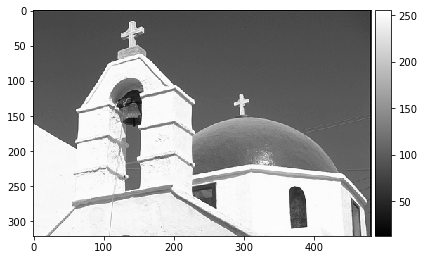

In [187]:
io.imshow(final_img_g, cmap='gray')
result.first[0]['t']

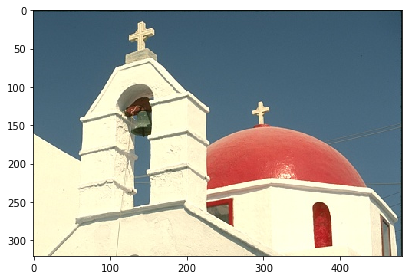

In [188]:
rgb_img_final = np.copy(rgb)
for i in range(r):
    for j in range(c):
        if final_img[i][j] == 0:
           rgb_img_final[i,j,:] = [0,0,0]

io.imshow(rgb_img_final)

In [189]:
result.first[0]['t']


-1